# N2 molecule eigenvalue estimation using vqe and qpe and subsequently ITPE

In [1]:
import numpy as np
import os
import sys
import pyscf
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import PhaseEstimation, TwoLocal
from qiskit.circuit.library import HamiltonianGate
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

### import nature library
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitMapper
import time
import inspect
from pprint import pprint

In [2]:
# Define the molecule
driver = PySCFDriver(
    atom="N 0 0 0; N 0 0 1.0975",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Run the driver to get the problem
problem = driver.run()

# Define the log output (here using stdout)
flog = sys.stdout

### Apply freezecore transformer
transformer = FreezeCoreTransformer()
problem = transformer.transform(problem)

hamiltonian = problem.hamiltonian.second_q_op()
#print(hamiltonian)
print("\n".join(str(hamiltonian).splitlines()[:10] + ["..."]))

Fermionic Operator
number spin orbitals=16, number terms=3288
  0.37410225454704793 * ( +_0 +_0 -_0 -_0 )
+ -0.05443765442389184 * ( +_0 +_0 -_4 -_0 )
+ 0.25609420108133757 * ( +_0 +_1 -_1 -_0 )
+ 0.03671071200315431 * ( +_0 +_1 -_7 -_0 )
+ 0.3088887300750244 * ( +_0 +_2 -_2 -_0 )
+ 0.3088887300750247 * ( +_0 +_3 -_3 -_0 )
+ -0.05443765442389184 * ( +_0 +_4 -_0 -_0 )
+ 0.2713425045755203 * ( +_0 +_4 -_4 -_0 )
...


In [3]:
print(problem.num_particles)
print(problem.num_spatial_orbitals)
#print(problem.active_orbitals)

(5, 5)
8


In [4]:
mapper = JordanWignerMapper()

pauli_hamiltonian = mapper.map(hamiltonian)
c = 0
for pauli, coeff in sorted(pauli_hamiltonian.label_iter()):
    c+= 1
    if c <10:
        print(f"{coeff.real:+.8f} * {pauli}")
    else:
        print("...")
        break

-25.66868383 * IIIIIIIIIIIIIIII
+1.06406699 * IIIIIIIIIIIIIIIZ
+0.68436479 * IIIIIIIIIIIIIIZI
+0.11401214 * IIIIIIIIIIIIIIZZ
+0.66055804 * IIIIIIIIIIIIIZII
+0.12815933 * IIIIIIIIIIIIIZIZ
+0.11484539 * IIIIIIIIIIIIIZZI
+0.66055804 * IIIIIIIIIIIIZIII
+0.12815933 * IIIIIIIIIIIIZIIZ
...


In [5]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

as_transformer = ActiveSpaceTransformer(2,2) # syntax = AST(num_electrons,num_orbitals)
as_problem = as_transformer.transform(problem)

print(as_problem.num_particles)
print(as_problem.num_spatial_orbitals)

(1, 1)
2


In [6]:
print(as_problem.hamiltonian.electronic_integrals.alpha)

Polynomial Tensor
 "+-":
array([[-1.12465081e+00, -3.28944424e-18],
       [-3.28944424e-18, -7.62075705e-01]])
 "++--":
array([[[[ 5.85155853e-01, -2.41691378e-17],
         [-2.41691378e-17,  5.40817488e-01]],

        [[-2.41691378e-17,  3.82404172e-02],
         [ 3.82404172e-02, -1.98289505e-17]]],


       [[[-2.41691378e-17,  3.82404172e-02],
         [ 3.82404172e-02, -1.98289505e-17]],

        [[ 5.40817488e-01, -1.98289505e-17],
         [-1.98289505e-17,  6.05101909e-01]]]])


In [7]:
hamiltonian = as_problem.hamiltonian.second_q_op()

#### Hilbert space reduction for pauli hamiltonian using AST

In [8]:
#convert second quantized operator into pauli strings using any chemistry encoding of choice. we use jw.
mapper = JordanWignerMapper()

pauli_hamiltonian = mapper.map(hamiltonian)

for pauli, coeff in sorted(pauli_hamiltonian.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

-1.06746480 * IIII
+0.15518780 * IIIZ
-0.03108626 * IIZI
+0.12564427 * IIZZ
+0.15518780 * IZII
+0.14628896 * IZIZ
+0.13520437 * IZZI
+0.00956010 * XXXX
+0.00956010 * XXYY
+0.00956010 * YYXX
+0.00956010 * YYYY
-0.03108626 * ZIII
+0.13520437 * ZIIZ
+0.15127548 * ZIZI
+0.12564427 * ZZII


In [9]:
pauli_hamiltonian

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-1.0674648 +0.j,  0.1551878 +0.j, -0.03108626+0.j,  0.12564427+0.j,
  0.1551878 +0.j,  0.14628896+0.j, -0.03108626+0.j,  0.13520437+0.j,
  0.0095601 +0.j,  0.0095601 +0.j,  0.0095601 +0.j,  0.0095601 +0.j,
  0.13520437+0.j,  0.15127548+0.j,  0.12564427+0.j])

In [10]:
eig = np.linalg.eigvals(pauli_hamiltonian)
print('NUMPY eig',np.min(eig))

estimator = Estimator()
optimizer = SLSQP()
ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')

vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator=pauli_hamiltonian)
print('VQE eig', result.eigenvalue)

NUMPY eig (-1.6661032295567362+0j)
VQE eig -1.6660830716762367


In [11]:
n_qpe_qbits = 10

U = HamiltonianGate(pauli_hamiltonian, 1, label='H')

# Obtain a solution via QPE
total_qbits = U.num_qubits + n_qpe_qbits
measure_circ = QuantumCircuit(total_qbits, n_qpe_qbits)
measure_circ.h([-1, -2])

qpe = PhaseEstimation(n_qpe_qbits, U)
Qpe=qpe.decompose().decompose().decompose().decompose().decompose().decompose().decompose()

In [12]:
measure_circ = measure_circ.compose(Qpe)
measure_circ.measure(range(n_qpe_qbits), range(n_qpe_qbits))

In [13]:
from qiskit_aer import Aer
backend=Aer.get_backend('aer_simulator')
job=backend.run(measure_circ,shots=10)
result=job.result()
counts = job.result().get_counts()
print(counts)

{'0000000000': 5, '1010110100': 1, '0011111000': 4}


In [14]:
list(counts.items())

[('0000000000', 5), ('1010110100', 1), ('0011111000', 4)]

In [30]:
max_count = max(counts.items(), key=lambda x: x[1])
print(f'MAX count: {max_count}')

theta = int(max_count[0][::-1], 2) / 2**n_qpe_qbits
print(f'Theta value: {theta}')
print(f'QPE-approximated U-eigenvalue: {np.exp(2*1j*np.pi * theta)}')
print(f'QPE-approximated H-eigenvalue: {-2 * np.pi * theta}')

MAX count: ('0000000000', 2)
Theta value: 0.0
QPE-approximated U-eigenvalue: (1+0j)
QPE-approximated H-eigenvalue: -0.0


## For different orientation of N2 molecule

In [16]:
driver = PySCFDriver(
    atom="N -1.05068773 0 0; N 1.05068773 0 0",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


# Run the driver to get the problem
problem = driver.run()

# Define the log output (here using stdout)
flog = sys.stdout

### Apply freezecore transformer
transformer = FreezeCoreTransformer()
problem = transformer.transform(problem)

hamiltonian = problem.hamiltonian.second_q_op()
#print(hamiltonian)
print("\n".join(str(hamiltonian).splitlines()[:10] + ["..."]))

Fermionic Operator
number spin orbitals=16, number terms=3288
  0.24020631525796093 * ( +_0 +_0 -_0 -_0 )
+ -0.020693007895257232 * ( +_0 +_0 -_2 -_0 )
+ 0.23165156172723073 * ( +_0 +_1 -_1 -_0 )
+ 0.021613616445664473 * ( +_0 +_1 -_7 -_0 )
+ -0.020693007895257232 * ( +_0 +_2 -_0 -_0 )
+ 0.23656395904636526 * ( +_0 +_2 -_2 -_0 )
+ 0.23560093073382013 * ( +_0 +_3 -_3 -_0 )
+ 0.23560093073381994 * ( +_0 +_4 -_4 -_0 )
...


In [17]:
print(problem.num_particles)
print(problem.num_spatial_orbitals)
#print(problem.active_orbitals)

(5, 5)
8


In [18]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

as_transformer = ActiveSpaceTransformer(2,2) # syntax = AST(num_electrons,num_orbitals)
as_problem = as_transformer.transform(problem)
print(as_problem.num_particles)
print(as_problem.num_spatial_orbitals)

(1, 1)
2


In [19]:
print(as_problem.hamiltonian.electronic_integrals.alpha)

Polynomial Tensor
 "+-":
array([[-7.20070885e-01, -3.49668136e-12],
       [-3.49645931e-12, -8.30967266e-01]])
 "++--":
array([[[[ 4.97554008e-01, -1.31690275e-12],
         [-1.31690275e-12,  4.60592077e-01]],

        [[-1.31690275e-12,  2.31059321e-02],
         [ 2.31059321e-02,  1.30134792e-12]]],


       [[[-1.31690275e-12,  2.31059321e-02],
         [ 2.31059321e-02,  1.30134792e-12]],

        [[ 4.60592077e-01,  1.30134792e-12],
         [ 1.30134792e-12,  5.06340300e-01]]]])


In [20]:
hamiltonian = as_problem.hamiltonian.second_q_op()

#convert second quantized operator into pauli strings using any chemistry encoding of choice. we use jw.
mapper = JordanWignerMapper()

pauli_hamiltonian = mapper.map(hamiltonian)

for pauli, coeff in sorted(pauli_hamiltonian.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

-0.85102546 * IIII
+0.01112738 * IIIZ
+0.06437900 * IIZI
+0.10937154 * IIZZ
+0.01112738 * IZII
+0.12438850 * IZIZ
+0.11514802 * IZZI
+0.00577648 * XXXX
+0.00577648 * XXYY
+0.00577648 * YYXX
+0.00577648 * YYYY
+0.06437900 * ZIII
+0.11514802 * ZIIZ
+0.12658507 * ZIZI
+0.10937154 * ZZII


In [21]:
print(pauli_hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.85102546+0.j,  0.01112738+0.j,  0.064379  +0.j,  0.10937154+0.j,
  0.01112738+0.j,  0.1243885 +0.j,  0.064379  +0.j,  0.11514802+0.j,
  0.00577648+0.j,  0.00577648+0.j,  0.00577648+0.j,  0.00577648+0.j,
  0.11514802+0.j,  0.12658507+0.j,  0.10937154+0.j])


In [22]:
eig = np.linalg.eigvals(pauli_hamiltonian)
print('NUMPY eig',np.min(eig))

estimator = Estimator()
optimizer = SLSQP()
ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')

vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator=pauli_hamiltonian)
print('VQE eig', result.eigenvalue)

NUMPY eig (-1.158071835347649+0j)
VQE eig -1.1135474584339797


In [23]:
n_qpe_qbits = 10

U = HamiltonianGate(pauli_hamiltonian, 1, label='H')

# Obtain a solution via QPE
total_qbits = U.num_qubits + n_qpe_qbits
measure_circ = QuantumCircuit(total_qbits, n_qpe_qbits)
measure_circ.h([-1, -2])

qpe = PhaseEstimation(n_qpe_qbits, U)
Qpe=qpe.decompose().decompose().decompose().decompose().decompose().decompose().decompose()

In [24]:
measure_circ = measure_circ.compose(Qpe)
measure_circ.measure(range(n_qpe_qbits), range(n_qpe_qbits))

#measure_circ.draw("mpl")

In [25]:
from qiskit_aer import Aer
backend=Aer.get_backend('aer_simulator')
job=backend.run(measure_circ,shots=10)
result=job.result()
counts = job.result().get_counts()
print(counts)

{'1000000100': 1, '0000000000': 2, '1110111000': 1, '0110110100': 2, '1010111000': 2, '1101000100': 1, '1010000100': 1}


In [26]:
list(counts.items())

[('1000000100', 1),
 ('0000000000', 2),
 ('1110111000', 1),
 ('0110110100', 2),
 ('1010111000', 2),
 ('1101000100', 1),
 ('1010000100', 1)]

In [27]:
max_count = max(counts.items(), key=lambda x: x[1])
print(f'MAX count: {max_count}')

theta = int(max_count[0][::-1], 2) / 2**n_qpe_qbits
print(f'Theta value: {theta}')
print(f'QPE-approximated U-eigenvalue: {np.exp(2*1j*np.pi * theta)}')
print(f'QPE-approximated H-eigenvalue: {-2 * np.pi * theta}')

MAX count: ('0000000000', 2)
Theta value: 0.0
QPE-approximated U-eigenvalue: (1+0j)
QPE-approximated H-eigenvalue: -0.0


In [28]:
from qiskit_algorithms.phase_estimators.phase_estimator import PhaseEstimator

In [29]:
eig = np.sort(eig)
eig

array([-1.15807184e+00+0.j, -1.11355201e+00+0.j, -1.11355201e+00+0.j,
       -1.11355201e+00+0.j, -1.06734014e+00+0.j, -9.77586895e-01+0.j,
       -9.77586895e-01+0.j, -9.40110158e-01+0.j, -8.75476806e-01+0.j,
       -8.75476806e-01+0.j, -8.30967266e-01+0.j, -8.30967266e-01+0.j,
       -7.20070885e-01+0.j, -7.20070885e-01+0.j, -3.02025550e-01+0.j,
        2.77555756e-17+0.j])

![quantum phase estimation circuit](qpe_circuit.png)
! <p style="text-align: center;">QPE circuit</p>

# Iterative QPE

### **refer to this [link to notebook for iqpe](https://github.com/qiskit-community/ibm-quantum-challenge-spring-2023/blob/main/content/lab_3/lab3.ipynb)**

Exponentiated pauli hamiltonian

### Method 1

In [49]:
from qiskit.circuit.library import PauliEvolutionGate

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


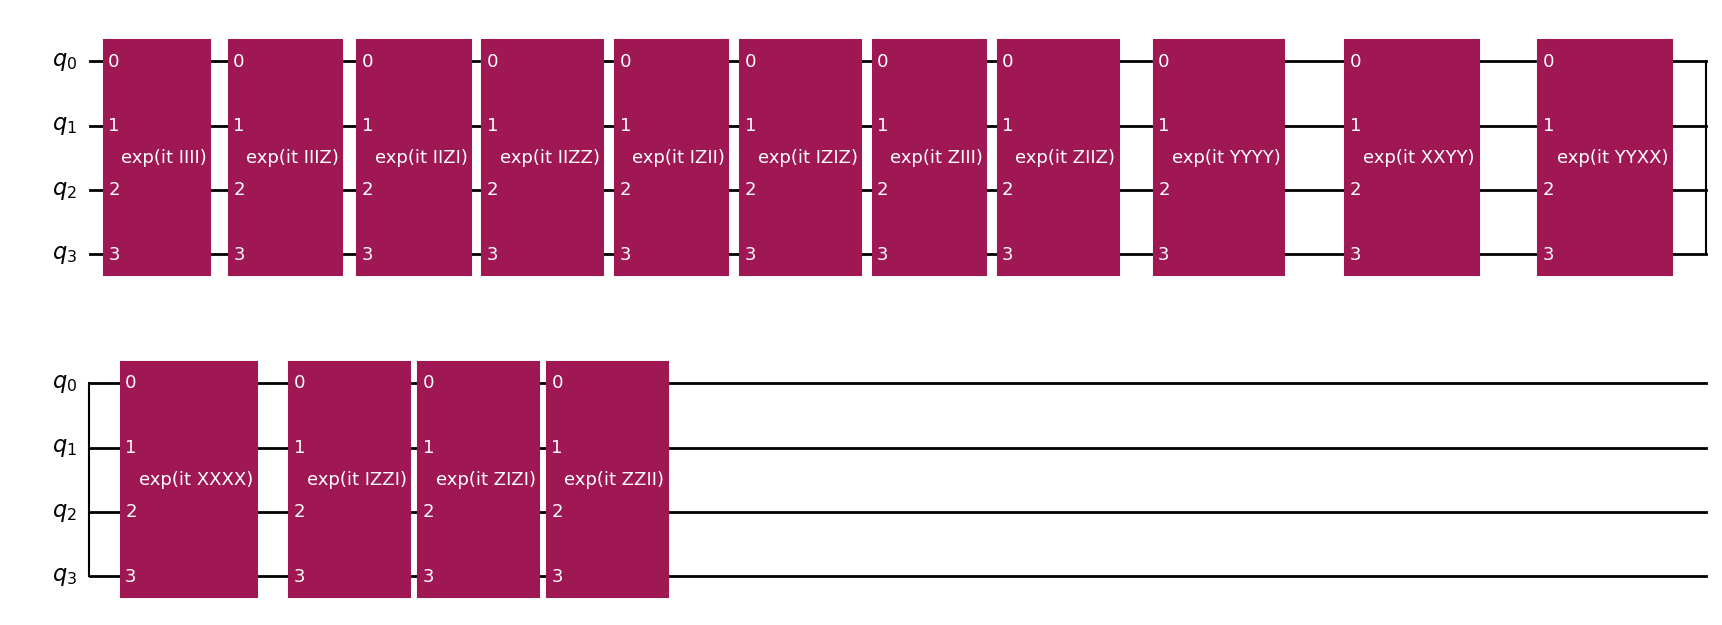

In [50]:
# Define parameters
n_qubits = 4  # active space
t = 1.0  # Time parameter
n_iterations = 100

# Create the unitary operator U = e^(-iHt)
instruct = PauliEvolutionGate(pauli_hamiltonian, time=1.0)
#print(type(U_2))
U_1 = QuantumCircuit(4)
U_1.append(instruct, range(4))
print(type(U_1))
U_draw = U_1.decompose()
U_draw.draw("mpl")

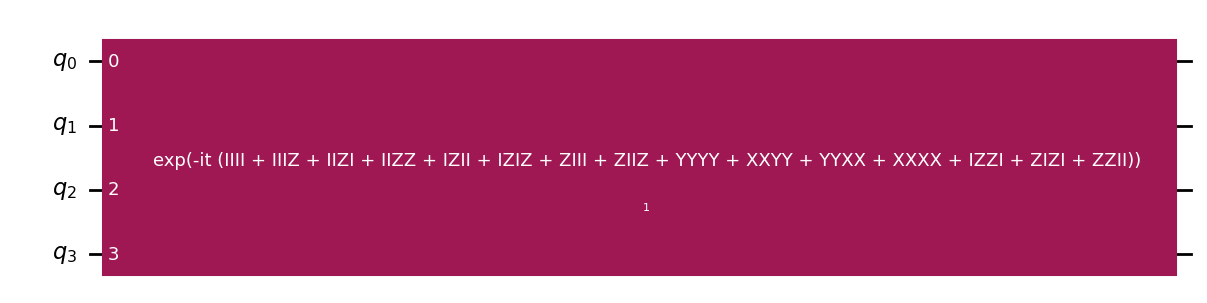

In [51]:
U_1.draw("mpl")

### Method 2

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


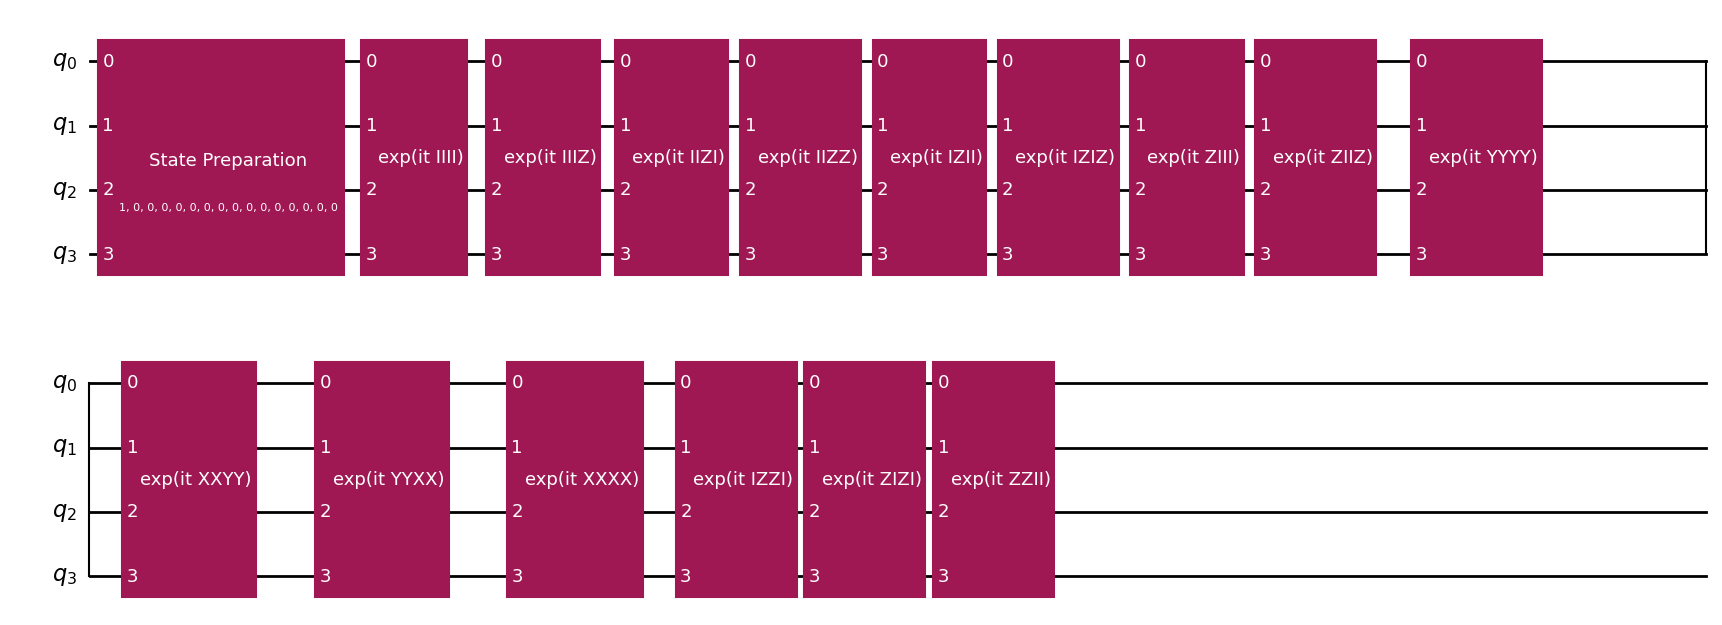

In [52]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE

initial_state = Statevector.from_label("0000")
problem = TimeEvolutionProblem(pauli_hamiltonian, initial_state=initial_state ,time=1.0)
trotter = TrotterQRTE()
result = trotter.evolve(problem)
U_2 = result.evolved_state
print(type(U_1))
U_2 = U_2.decompose()
U_2.draw("mpl")

# We will use method 1 i.e U_1

In [54]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

exp_ham_gate = U_1.to_gate(label = "U_ham_gate")

In [88]:
n_estimation_qubits = 1
n_system_qubits = U_1.num_qubits

def iqpe_rep_routine(target_wire,n_estimation_qubits = 1):
    #n_estimation_qubits = 1
    qr_est = QuantumRegister(n_estimation_qubits, 'e')
    qr_system = QuantumRegister(n_system_qubits, 's')
    cr = ClassicalRegister(n_estimation_qubits, 'c')
    
    
    qc = QuantumCircuit(qr_est, qr_system, cr)

    qc.h(range(n_estimation_qubits))
    #qc.draw("mpl")

    reps = 3
    control_gate = U_2.control(1)

    for _ in range(2**reps):
        qc.append(control_gate,[target_wire] + list(range(n_estimation_qubits, n_estimation_qubits+n_system_qubits)))

    qc.h(range(n_estimation_qubits))

    #qc = qc.decompose()
    #qc.draw("mpl")
    
    #return qc.to_gate()
    qc.barrier()
    qc.measure(qr_est, cr)
    
    return qc

### Test above function

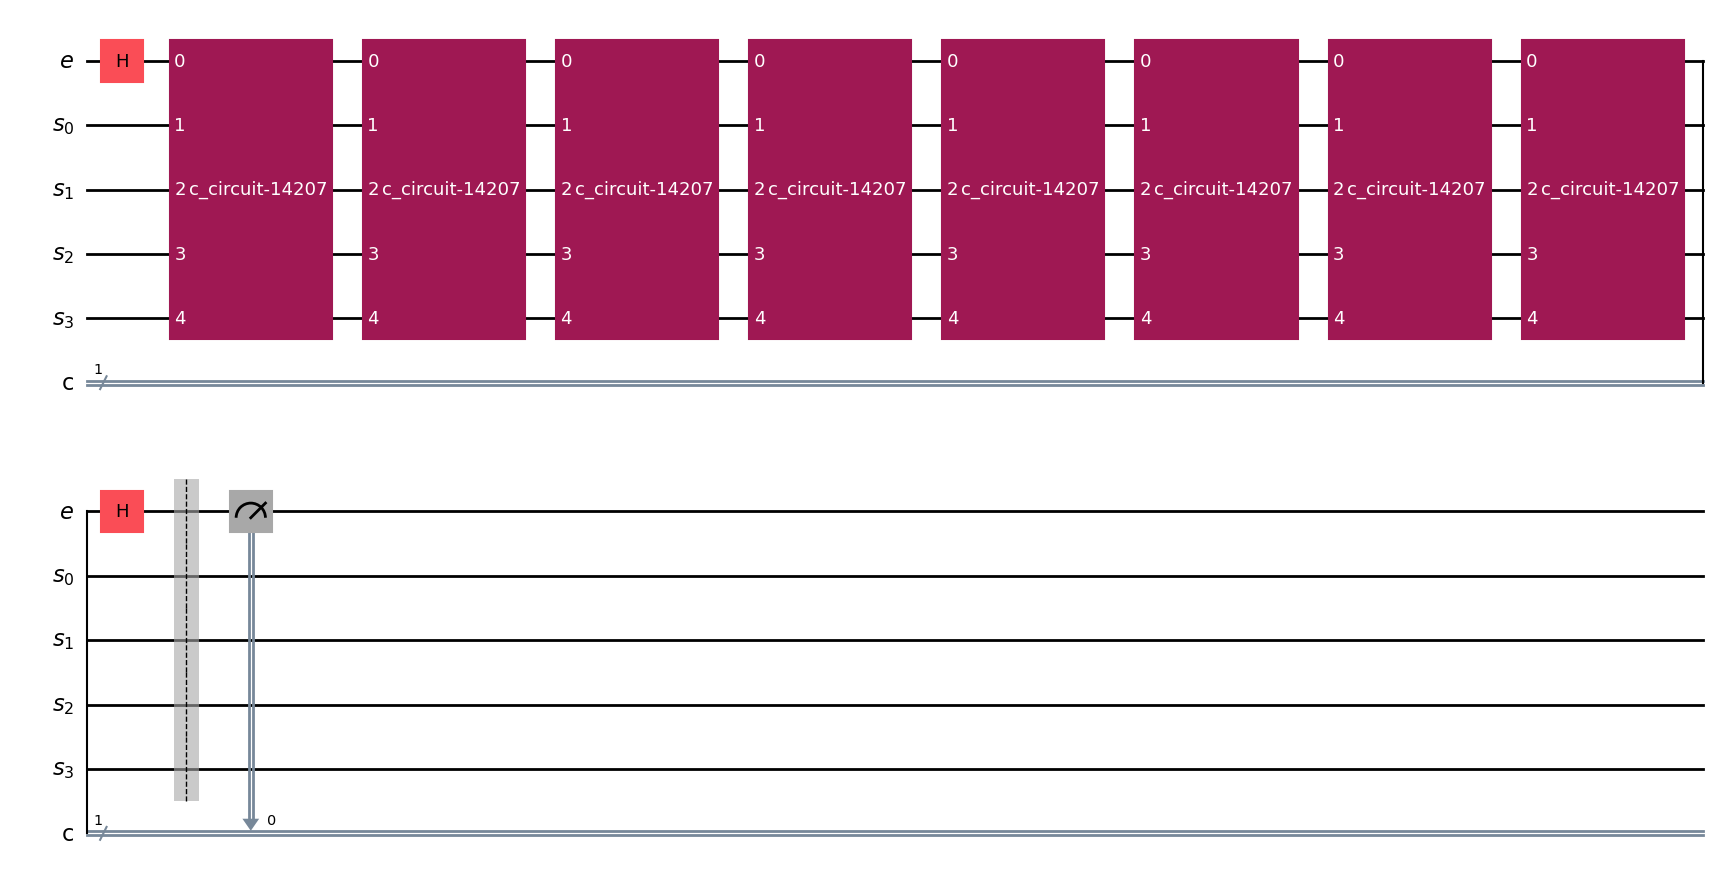

In [89]:
sample_qc = iqpe_rep_routine(0) #, range(n_estimation_qubits + U_1.num_qubits) #QuantumCircuit(n_estimation_qubits + U_1.num_qubits, n_estimation_qubits)
#sample_qc = sample_qc.append(iqpe_rep_routine(0), range(n_estimation_qubits + U_1.num_qubits))
#sample_qc = sample_qc.compose(iqpe_rep_routine(0), range(n_estimation_qubits + U_1.num_qubits))
sample_qc.draw("mpl")

In [96]:
def iterative_phase_estimation(n_system_qubits, n_estimation_qubits, n_iterations):
    
    phase_estimate = 0
    measure_circ = QuantumCircuit(n_system_qubits+n_estimation_qubits, n_estimation_qubits)
    
    for k in range(n_iterations):
        qc = iqpe_rep_routine(0)
        
        backend = Aer.get_backend('aer_simulator')
        job=backend.run(measure_circ,shots=1024)
        result=job.result()
        #counts = job.result().get_counts()
        
        if '1' in result and result['1'] > result.get('0', 0):
            value = int(max(counts, key=counts.get))
            phase += value / 2 ** (k + 1)
        
        print(f"Iteration {k+1}: Current phase estimate = {phase_estimate}")
    
    return phase_estimate

In [97]:
sample_qc.num_clbits

1

In [98]:
# Parameters
n_system_qubits = 4
n_estimation_qubits = 1
n_iterations = 10

# Run the iterative phase estimation
estimated_phase = iterative_phase_estimation(n_system_qubits, n_estimation_qubits, n_iterations)
estimated_phase

TypeError: argument of type 'Result' is not iterable